In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf

In [2]:
path = pathlib.Path('annotations/trimaps/')
sorted(path.glob('*.png')) == list(path.glob('*.png'))

True

In [3]:
path2 = pathlib.Path('images/')
sorted(path.glob('*.png')) == list(path.glob('*.png'))

True

In [4]:
input_ = list(path2.glob('*.jpg'))

In [5]:
target = list(path.glob('*.png'))

In [6]:
y  = tf.keras.preprocessing.image.load_img(input_[0], target_size=(160,160), color_mode='grayscale')

In [7]:
np.array(y)

array([[33, 35, 38, ..., 49, 47, 46],
       [33, 36, 38, ..., 51, 49, 48],
       [35, 36, 38, ..., 52, 49, 47],
       ...,
       [16, 18, 18, ..., 21, 22, 22],
       [16, 16, 16, ..., 22, 21, 19],
       [15, 15, 15, ..., 20, 19, 19]], dtype=uint8)

In [8]:
class OxfordPet(tf.keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, input_path, target_path):
        super().__init__()
        self.batch_size = batch_size
        self.w, self.h = img_size
        self.input_path = input_path
        self.target_path = target_path

    def __getitem__(self, x):
        idx = x * self.batch_size
        batch_input = self.input_path[idx:idx+self.batch_size]
        batch_target = self.target_path[idx:idx+self.batch_size]
        X = np.zeros((self.batch_size, self.w,self.h,3), dtype=np.float32)
        for i, j in enumerate(batch_input):
            X[i] = tf.keras.preprocessing.image.load_img(j, target_size=(self.w, self.h))
        y = np.zeros((self.batch_size, self.w, self.h,1), dtype=np.uint8)
        for i, j in enumerate(batch_target):
            y[i] = np.array(tf.keras.preprocessing.image.load_img(j, target_size=(self.w, self.h), color_mode='grayscale'))[...,np.newaxis]
        return X,y
    
    def __len__(self):
        return len(self.target_path) // self.batch_size

In [9]:
op = OxfordPet(32, (160,160), input_, target)

In [14]:
xe = tf.keras.applications.Xception()
xe.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [132]:
u = []
input_ = tf.keras.Input((160,160,3))

# contracting path
x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(input_)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

pa = x
u.append(pa)

In [133]:
for f in [64, 128, 256]:
    x = tf.keras.layers.SeparableConv2D(f, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(3, 2, padding='same')(x)
    
    short = tf.keras.layers.Conv2D(f, 1, strides=2, padding='same')(pa)
    x = tf.keras.layers.Add()([x, short])
    pa = x
    u.append(pa)

In [134]:
us = list(reversed(u))

In [135]:
# expanding path
for i,f in enumerate([256, 128, 64, 32]):
    x = tf.keras.layers.Conv2DTranspose(f, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Concatenate()([x, us[i]]) # add
    x = tf.keras.layers.UpSampling2D()(x)

In [136]:
x = tf.keras.layers.Conv2D(3, 3, padding='same', activation='softmax')(x)
model = tf.keras.Model(input_, x)

In [137]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_92 (Conv2D)             (None, 80, 80, 32)   896         ['input_27[0][0]']               
                                                                                                  
 batch_normalization_143 (Batch  (None, 80, 80, 32)  128         ['conv2d_92[0][0]']              
 Normalization)                                                                                   
                                                                                           

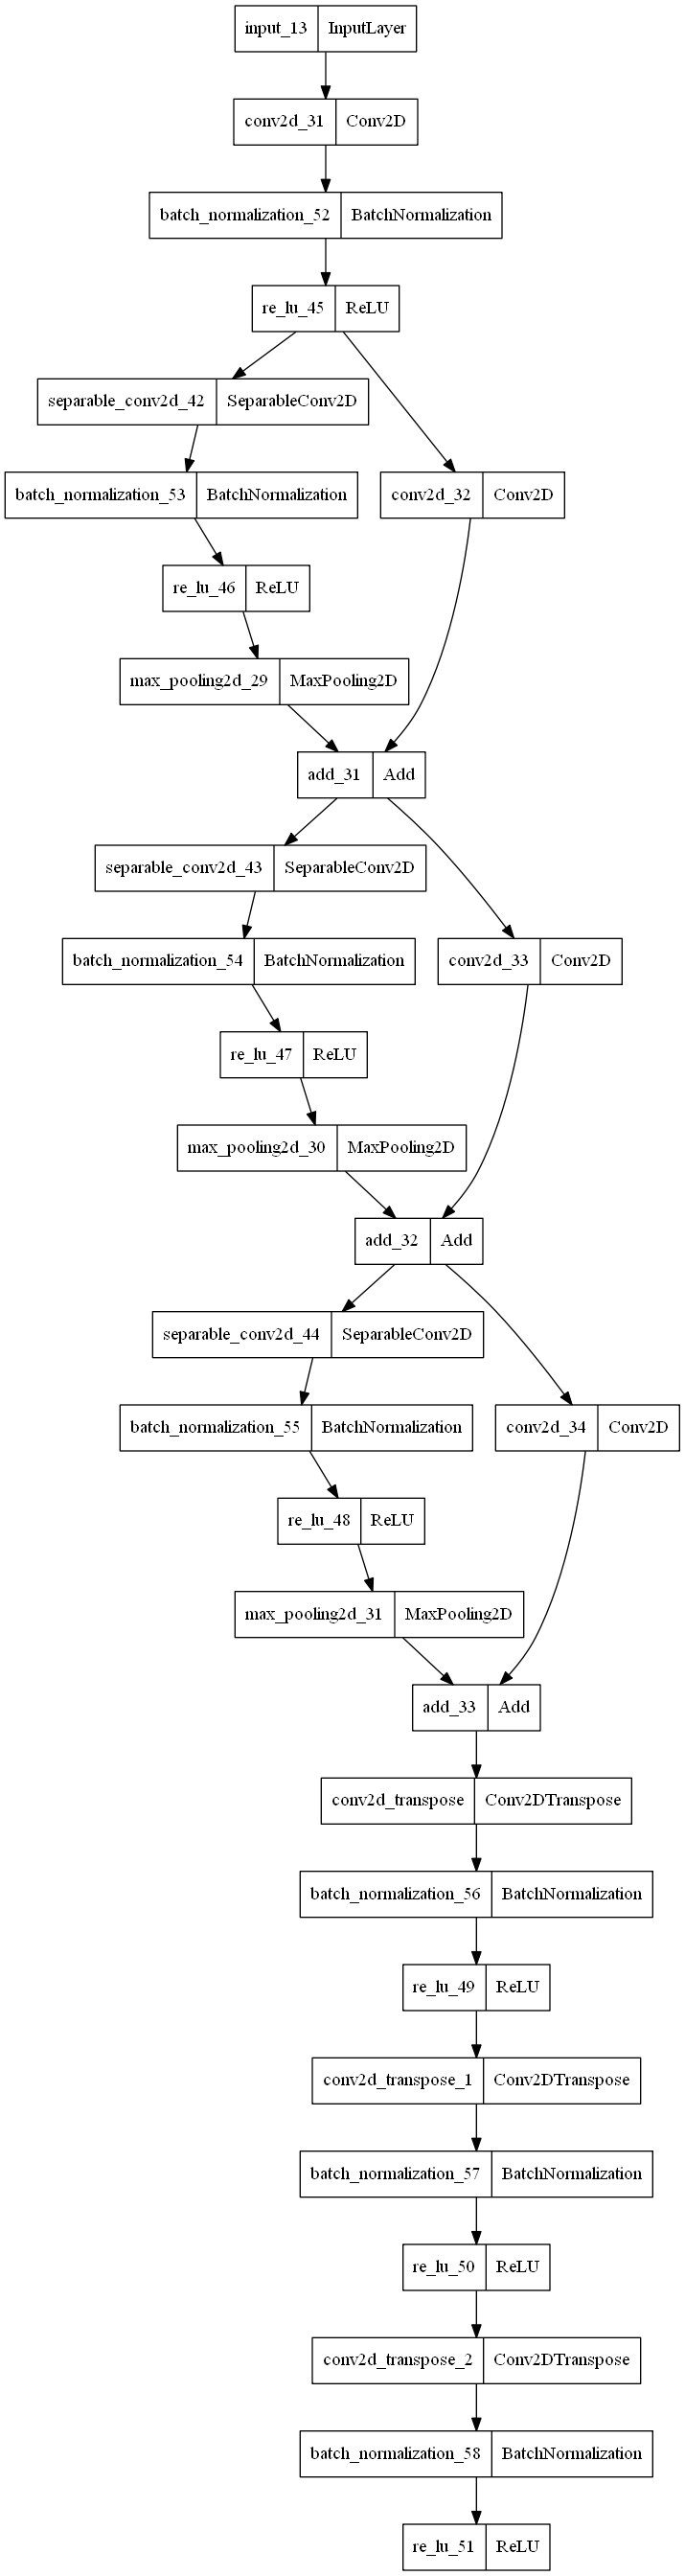

In [57]:
tf.keras.utils.plot_model(model)